In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from pymongo import MongoClient
from datetime import datetime
from os import path
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle5 as pickle
import yaml
import os
import umap

<IPython.core.display.Javascript object>

In [3]:
mongourl = "mongodb://localhost:27017"
client = MongoClient(mongourl)

<IPython.core.display.Javascript object>

In [4]:
START = datetime(2019, 12, 1, 0, 0)
END = datetime(2020, 8, 1, 0, 0)

n_dims = 50
bert_embedding_size = 768
num_topics = 5

<IPython.core.display.Javascript object>

In [5]:
q = {"bertEncoding": {"$exists": True}}

<IPython.core.display.Javascript object>

In [29]:
CHUNK_SIZE = 10000
coll = client["news"]["article"]
cursor = coll.find(q, batch_size=CHUNK_SIZE)


def yield_rows(cursor, chunk_size):
    """
    Generator to yield chunks from cursor
    :param cursor:
    :param chunk_size:
    :return:
    """
    chunk = []
    for i, row in enumerate(cursor):
        if i % chunk_size == 0 and i > 0:
            yield chunk
            del chunk[:]
        chunk.append(row)
    yield chunk

<IPython.core.display.Javascript object>

In [7]:
def reduce_dim(docs, n_dims):
    pca = PCA(n_components=n_dims, random_state=7)
    res_pca = pca.fit_transform(docs)
    print("Shape after PCA: ", res_pca.shape)
    reducer = umap.UMAP(n_neighbors=n_dims, min_dist=0.5)
    res_umap = reducer.fit_transform(docs)
    print("Shape after UMAP: ", res_umap.shape)
    return res_umap

<IPython.core.display.Javascript object>

In [63]:
def plot_dim_reduction(data, num_topics, topic_numbers, topic_tokens, file_name):
    color_map = []
    for i in range(num_topics):
        color_map.append(1 / (num_topics * 2) + (i / (num_topics)))
    # color_map = plt.cm.get_cmap("inferno", num_topics)
    # print(color_map)
    colors = []
    classes = []
    for t in topic_numbers:
        colors.append(color_map[t])
    # print(colors)
    for i in range(num_topics):
        classes.append(topic_tokens[i])
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(file_name, fontsize=20)
    scatter = plt.scatter(data[:, 0], data[:, 1], s=100, c=colors, alpha=0.5)
    plt.legend(
        handles=scatter.legend_elements()[0],
        labels=classes,
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
        fontsize="small",
    )

    plt.show()
    # plt.savefig("{}/{}.pdf".format("dim_red_fig", file_name), dpi=300)

<IPython.core.display.Javascript object>

In [30]:
topic_tokens = {}

<IPython.core.display.Javascript object>

In [31]:
chunks = yield_rows(cursor, CHUNK_SIZE)
embeddings = []
topic_numbers = []
chunk_idx = 0
for chunk in chunks:
    # do processing here
    print("CHUNK {}".format(chunk_idx))
    if chunk_idx > 0:
        break
    doc_idx = 0
    for doc in chunk:
        if doc_idx % 2000 == 0:
            print("PROCESSED DOC IN CHUNK: {}".format(doc_idx))
        if len(doc["bertEncoding"]) > 0:
            embeddings = np.append(embeddings, np.array(doc["bertEncoding"]))

            for topic_ in doc["topicExtraction"]:
                if int(topic_["topic_number"]) not in topic_tokens:
                    topic_tokens[int(topic_["topic_number"])] = [
                        elem["token"] for elem in topic_["topic_tokens"]
                    ]
            # topic_probs = [el["topic_prob"] for el in doc["testTopicExtraction"]]
            topic_probs = [el["topic_prob"] for el in doc["topicExtraction"]]
            topic_max_prob = np.argmax(topic_probs)
            # doc_topic_max_prob = doc["testTopicExtraction"][topic_max_prob]
            doc_topic_max_prob = doc["topicExtraction"][topic_max_prob]
            topic_numbers = np.append(topic_numbers, doc_topic_max_prob["topic_number"])
        doc_idx += 1
    chunk_idx += 1

CHUNK 0
PROCESSED DOC IN CHUNK: 0
PROCESSED DOC IN CHUNK: 2000
PROCESSED DOC IN CHUNK: 4000
PROCESSED DOC IN CHUNK: 6000
PROCESSED DOC IN CHUNK: 8000
CHUNK 1


<IPython.core.display.Javascript object>

In [32]:
print("Found some articles")
topic_numbers = np.asarray(topic_numbers)
topic_numbers = topic_numbers.astype("int32")
embeddings = np.reshape(embeddings, (-1, bert_embedding_size))
print(embeddings.shape)
print("Reducing dimensions")
results = reduce_dim(embeddings, n_dims)
print(results.shape)

Found some articles
(9807, 768)
Reducing dimensions
Shape after PCA:  (9807, 50)
Shape after UMAP:  (9807, 2)
(9807, 2)


<IPython.core.display.Javascript object>

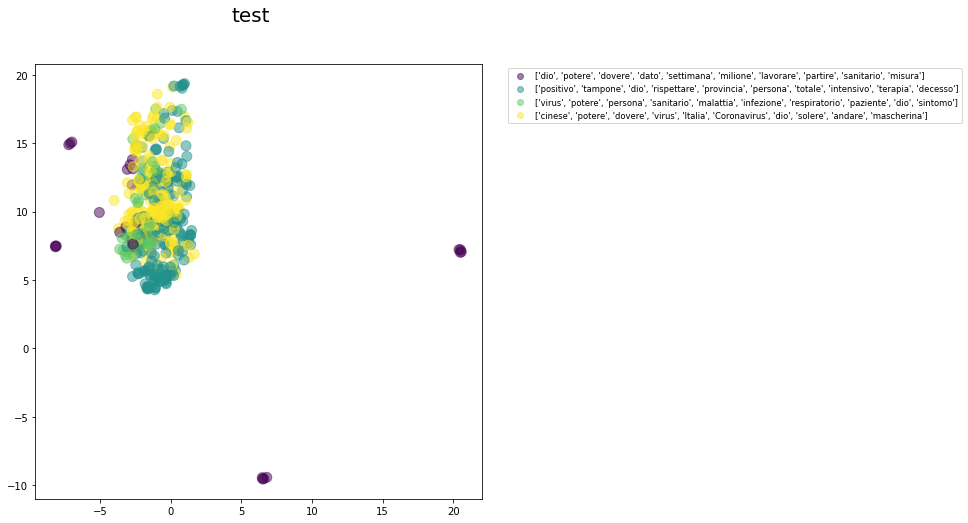

<IPython.core.display.Javascript object>

In [65]:
plot_dim_reduction(results[:500], num_topics, topic_numbers[:500], topic_tokens, "test")